# 理论知识
# 截图

# 1 sklearn.cluster.KMeans
class sklearn.cluster.KMeans (n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001,precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm=’auto’)


## 1.1 重要参数n_clusters
n_clusters是KMeans中的k，表示着我们告诉模型我们要**分几类**。这是KMeans当中唯一一个必填的参数，默认为8类，但通常我们的聚类结果会是一个小于8的结果。通常，在开始聚类之前，我们并不知道n_clusters究竟是多少，因此我们要对它进行探索。

### 1.1.1 小试牛刀
当我们拿到一个数据集，如果可能的话，我们希望能够通过**绘图先观察**一下这个数据集的数据分布，以此来为我们聚类时输入的n_clusters做一个参考。

首先，我们来自己创建一个数据集。这样的数据集是我们自己创建，所以是有标签的。

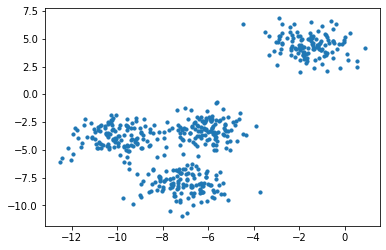

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=500, n_features=2, centers=4, random_state=1)
fig, ax1 = plt.subplots(1)
ax1.scatter(X[:, 0], X[:, 1], marker='o', s=10)  # 点的形状为圆形，大小为10
plt.show()

初步看数据大概有4簇。因为这个数据集我们已知其标签，所以如果想要好看点，可以根据不同y加上不同颜色：

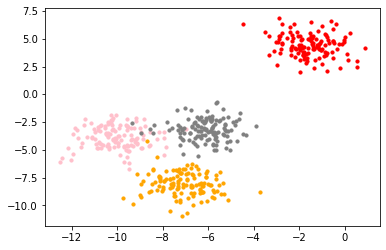

In [89]:
color = ["red", "pink", "orange", "gray"]
fig, ax1 = plt.subplots(1)
for i in range(4):
    ax1.scatter(X[y == i, 0], X[y == i, 1], marker='o', s=10, c=color[i])  # 点的形状为圆形，大小为10
plt.show()

接下来使用Kmeans进行聚类。

In [5]:
from sklearn.cluster import KMeans

n_clusters = 3
cluster = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
# KMeans因为并不需要建立模型或者预测结果，因此只需要fit就能够得到聚类结果了
y_pred = cluster.labels_  # 查看每个样本所聚好的类别

# 截图
执行上述代码时系统会有上述警告信息，如果你不介意可以不管，不影响后面执行；介意的话，可以参考[解决方案](https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am)。

In [3]:
pre = cluster.fit_predict(X)  # 也可直接用fit_predict一步到位，跟上面是一样的效果
(pre == y_pred).sum()  # 理所当然为500

500

KMeans还有个predict，什么时候使用：数据量很大时，因为此时我们不必使用所有数据来确定质心可以使用部分数据fit后，再用predict去预测剩余的大量数据，尽管会有一些数据聚类错误，但当不要求那么精确时，可以节省时间

In [93]:
cluster_smallsub = KMeans(n_clusters=n_clusters, random_state=0).fit(X[:250])  # 使用部分样本进行训练
y_pred_ = cluster_smallsub.predict(X)
(y_pred == y_pred_).sum()  # 可见使用部分数据训练再predict其他数据时会有一些数据聚类错误

125

cluster_centers_查看质心坐标

In [ ]:
centroid = cluster.cluster_centers_
centroid

inertia_查看总距离平方和

In [95]:
inertia = cluster.inertia_
inertia

1903.5607664611762

查看聚类的图像结果：

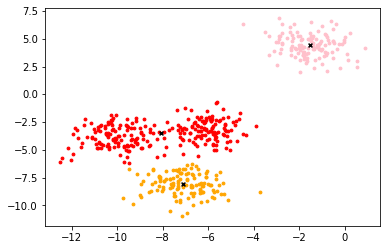

In [96]:
color = ["red", "pink", "orange", "gray"]
fig, ax1 = plt.subplots(1)
for i in range(n_clusters):
    ax1.scatter(X[y_pred == i, 0], X[y_pred == i, 1], marker='o', s=8, c=color[i])
ax1.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=15, c="black")
plt.show()

如果增大簇数呢？

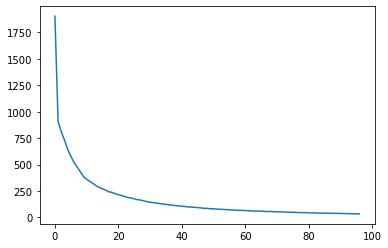

In [97]:
inertia_list = []
for n_clusters in range(3, 100):
    cluster_ = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia_ = cluster_.inertia_
    inertia_list.append(inertia_)
plt.plot(inertia_list)
plt.show()

可以发现随着簇数n_clusters增加，inertia逐渐减少（通过常识也知道，质心越多，总距离平方和越小），但并不代表它越小模型效果就越好。

### 1.1.2 模型评估指标
不同于分类模型和回归，聚类算法的模型评估不是一件简单的事。在分类中，有直接结果（标签）的输出，并且分类的结果有正误之分，所以我们使用预测的准确度，混淆矩阵，ROC曲线等等指标来进行评估，但无论如何评估，都是在”模型找到正确答案“的能力。而回归中，由于要拟合数据，我们有SSE均方误差，有损失函数来衡量模型的拟合程度。但这些衡量指标都不能够使用于聚类。

#### 轮廓系数
# 截图

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

X  # (500,2)
y_pred  # 每个样本所聚好的类别

# 返回一个数据集中，所有样本的轮廓系数的均值
silhouette_score(X, y_pred)  # 0.5882004012129721

# 返回数据集中每个样本自己的轮廓系数
silhouette_samples(X, y_pred)

轮廓系数有很多优点，它在有限空间中取值，使得我们对模型的聚类效果有一个“参考”。并且，轮廓系数对数据的分布没有假设，因此在很多数据集上都表现良好。但它在每个簇的分割比较清洗时表现最好。但轮廓系数也有缺陷，它在凸型的类上表现会虚高，比如基于密度进行的聚类，或通过DBSCAN获得的聚类结果，如果使用轮廓系数来衡量，则会表现出比真实聚类效果更高的分数。

#### Calinski-Harabaz Index
# 截图

In [14]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz_score(X, y_pred)  # 1809.991966958033

虽然calinski-Harabaz指数没有界，在凸型的数据上的聚类也会表现虚高。但是比起轮廓系数，它有一个巨大的优点，就是**计算非常快速**。之前使用过魔法命令%%timeit来计算一个命令的运算时间，这次来选择另一种方法：时间戳计算运行时间。

In [30]:
from time import time

t0 = time()
calinski_harabasz_score(X, y_pred)
time() - t0

t1 = time()
silhouette_score(X, y_pred)
time() - t1

import datetime

# 转换成人看的懂时间
datetime.datetime.fromtimestamp(t0).strftime("%Y-%m-%d %H:%M:%S")

'2023-04-09 01:01:19'

可以看得出，calinski-harabaz指数比轮廓系数的计算块了一倍不止。如果使用的数据量是一个以万计的数据，使用轮廓系数就会大大拖慢我们模型的运行速度。

### 1.1.3 案例：基于轮廓系数来选择n_clusters
我们通常会绘制轮廓系数分布图和聚类后的数据分布图来选择我们的最佳n_clusters。绘图过程比较难，立即推，学习到两点！

For n_clusters = 4 The average silhouette_score is : 0.6505186632729437


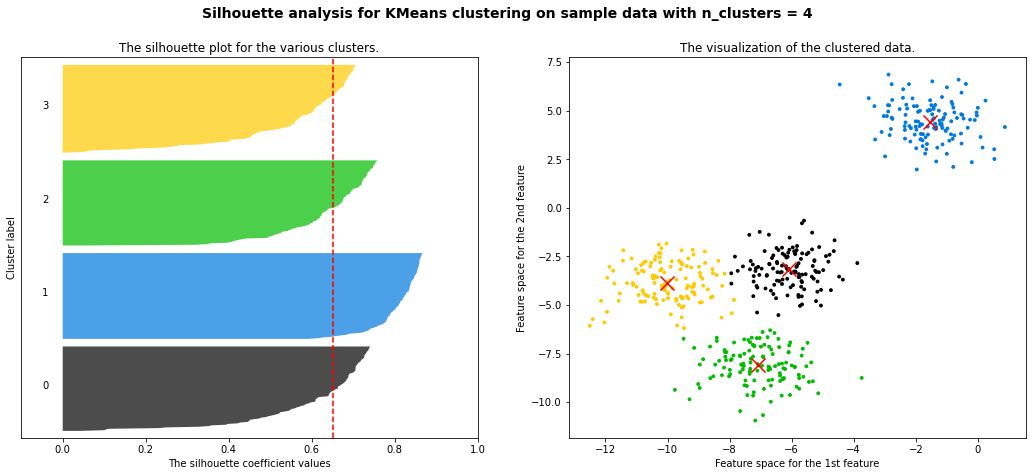

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

n_clusters = 4
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)  #画布尺寸
#第一个图横坐标是轮廓系数，纵坐标是各个样本,每个簇是一条
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

#开始建模
clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
cluster_labels = clusterer.labels_  #聚类结果:标签值

#总的轮廓系数
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters, "The average silhouette_score is :",
      silhouette_avg)

#每个样本点的轮廓系数,这就是横坐标
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10  #设定图像最低水平线

#对每一个簇进行循环
for i in range(n_clusters):
    #从每个样本的轮廓系数结果中抽取第i个簇的轮廓系数，并进行排序
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()  #排序，为了图像好看，从小到大
    size_cluster_i = ith_cluster_silhouette_values.shape[0]  #查看这一个簇中有多少个样本
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    #填充子图1
    ax1.fill_betweenx(np.arange(y_lower, y_upper),  # 范围内柱状图统一颜色
                      ith_cluster_silhouette_values,  # 柱状图横坐标
                      facecolor=color,
                      alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))  #编号

    y_lower = y_upper + 10

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

#把全体样本平均轮廓系数显示在图中
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])

#第二个图
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='o', s=8, c=colors)

#把生成的质心放到图中
centers = clusterer.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', alpha=1, s=200)

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14,
             fontweight='bold')
plt.show()

将上述过程包装成一个循环，可以得到：

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765
For n_clusters = 7 The average silhouette_score is : 0.39092211029930857


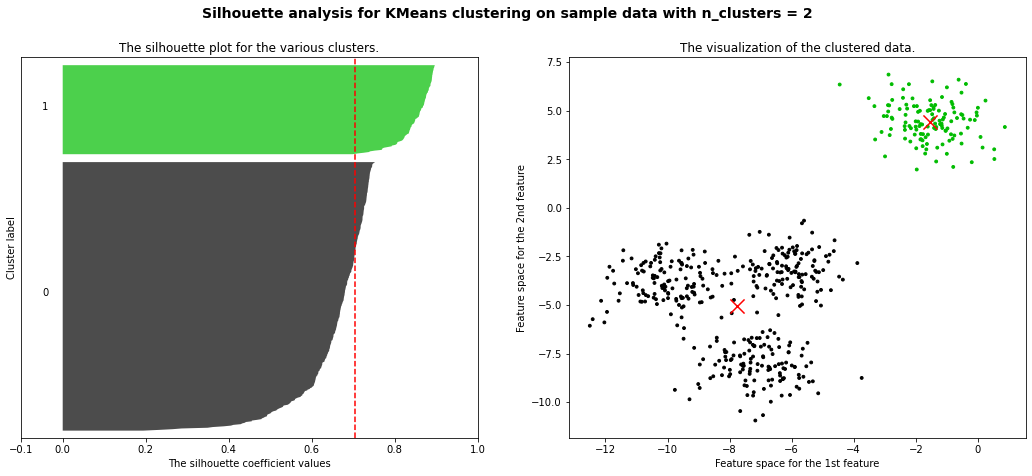

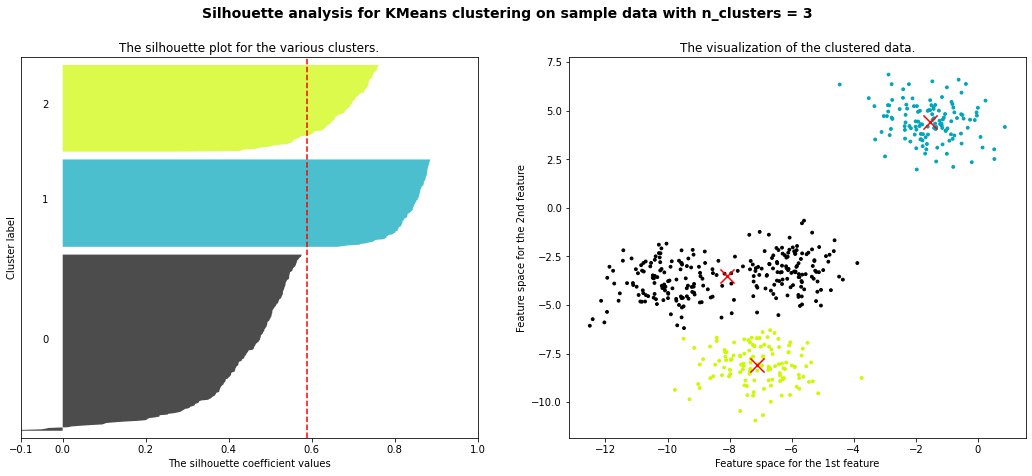

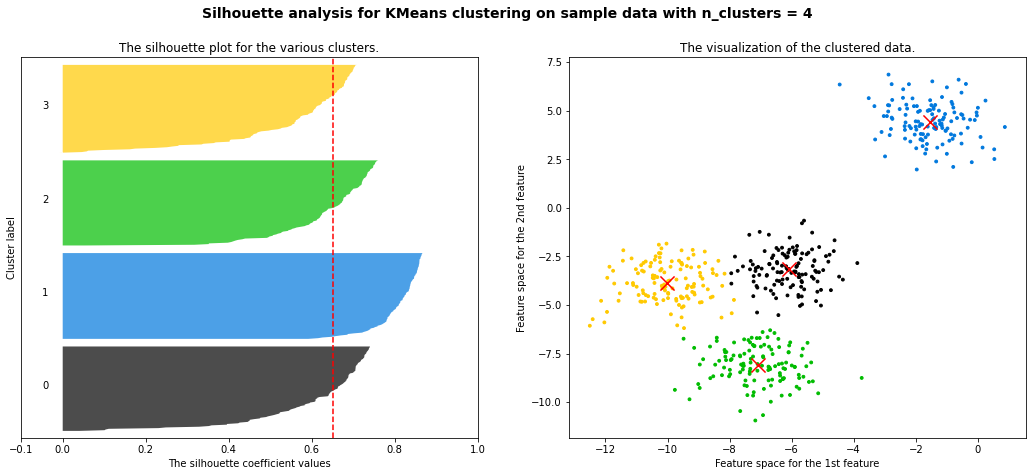

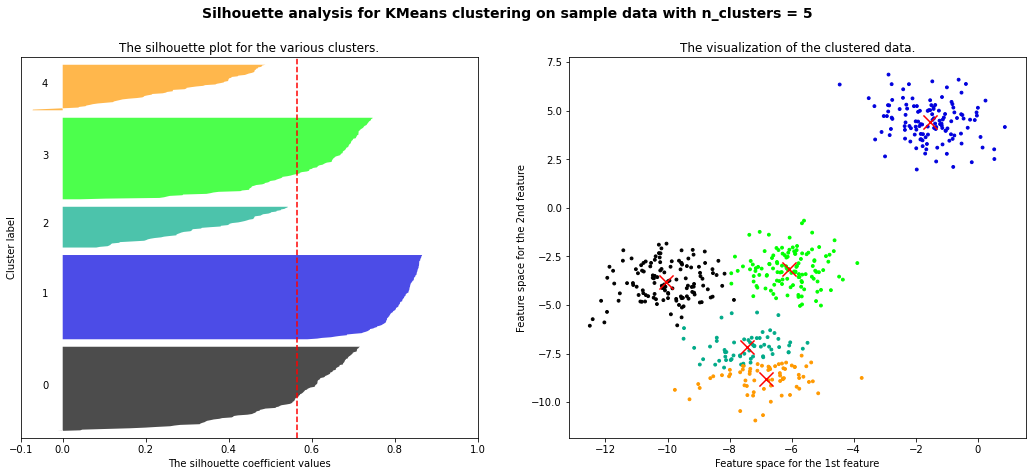

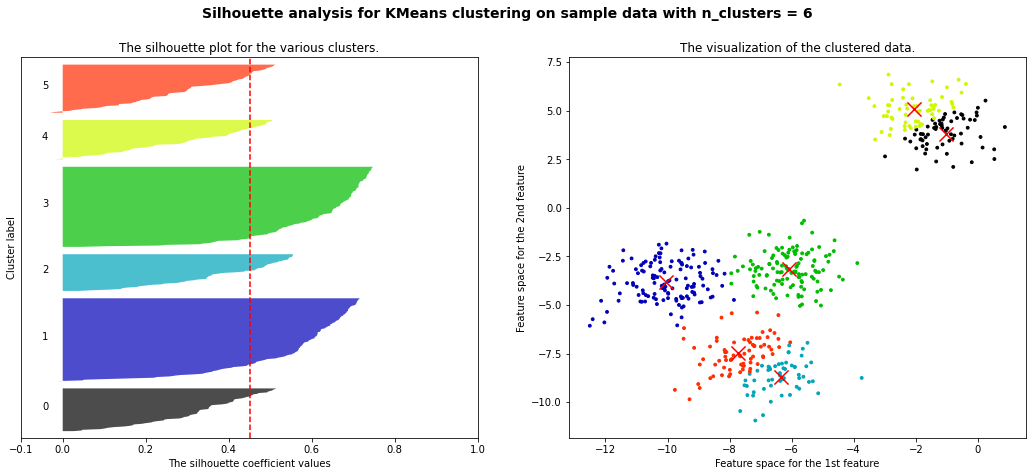

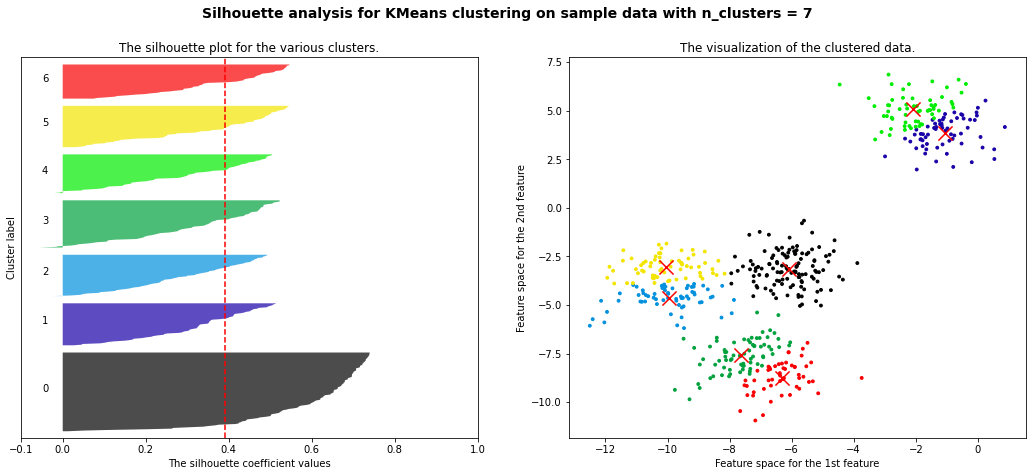

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

for n_clusters in [2, 3, 4, 5, 6, 7]:
    n_clusters = n_clusters
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :",
          silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels
                                                                 == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=8, c=colors)
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='x', c="red", alpha=1, s=200)
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14,
                 fontweight='bold')
plt.show()

由此可知，分2簇和4簇都是可以的，那么到底分几簇呢？这时就需要结合具体业务和目的去决定了。

## 1.2 重要参数init & random_state & n_init：初始质心怎么放好?

# 截图

In [22]:
from time import time

t0 = time()
plus = KMeans(n_clusters=10).fit(X)  # init默认为k-means++
print(plus.n_iter_)  # 迭代次数
print(time() - t0)  # 迭代次数少，但时间长（使用k-means++会有个计算过程）

16
0.5312621593475342


In [23]:
t0 = time()
random = KMeans(n_clusters=10, init="random", random_state=420).fit(X)  #init设置random比较一下
print(random.n_iter_)
print(time() - t0)  # 迭代次数多，但时间短

19
0.4864046573638916


## 1.3 重要参数max_iter & tol：让迭代停下来


在之前描述K-Means的基本流程时我们提到过，当质心不再移动，Kmeans算法就会停下来。但在完全收敛之前，我们也可以使用max_iter，最大迭代次数，或者tol，两次迭代间Inertia下降的量，这两个参数来让迭代提前停下来。有时候，当我们的n_clusters选择不符合数据的自然分布，或者我们为了业务需求，必须要填入与数据的自然分布不合的n_clusters，提前让迭代停下来反而能够提升模型的表现。

**max_iter**：整数，默认300，单次运行的k-means算法的最大迭代次数

**tol**：浮点数，默认1e-4，两次迭代间Inertia下降的量，如果两次迭代之间Inertia下降的值小于tol所设定的值，迭代就会停下

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score

random = KMeans(n_clusters=10, init="random", max_iter=10, random_state=420).fit(X)
y_pred_max10 = random.labels_
silhouette_score(X, y_pred_max10)  # 轮廓系数均值，越接近1越好

0.3952586444034157

In [32]:
random = KMeans(n_clusters=10, init="random", max_iter=20, random_state=420).fit(X)
y_pred_max20 = random.labels_
silhouette_score(X, y_pred_max20)

0.3401504537571701

以上可以看出有时候迭代次数大，模型效果还不一定好，故某些情况让模型提前停下来反而会提升模型效果。

## 1.4

## 1.5 函数cluster.k_means
sklearn.cluster.k_means (X, n_clusters, sample_weight=None, init=’k-means++’, precompute_distances=’auto’,n_init=10, max_iter=300, verbose=False, tol=0.0001, random_state=None, copy_x=True, n_jobs=None,algorithm=’auto’, return_n_iter=False)

聚类算法Kmeans函数k_means的用法其实和类非常相似，不过函数是输入一系列值，而直接返回结果。一次性地，函数k_means会依次返回质心，每个样本对应的簇的标签，inertia以及最佳迭代次数。

In [7]:
from sklearn.cluster import k_means

k_means(X, 4, return_n_iter=True)

# 2 案例：聚类算法用于降维，KMeans的矢量量化应用
# 截图

**1.导入需要的库**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image  # 加载图片
from sklearn.utils import shuffle  # 打乱数据
from sklearn.metrics import pairwise_distances_argmin  # 计算最近的质心

**2.导入数据，探索数据**

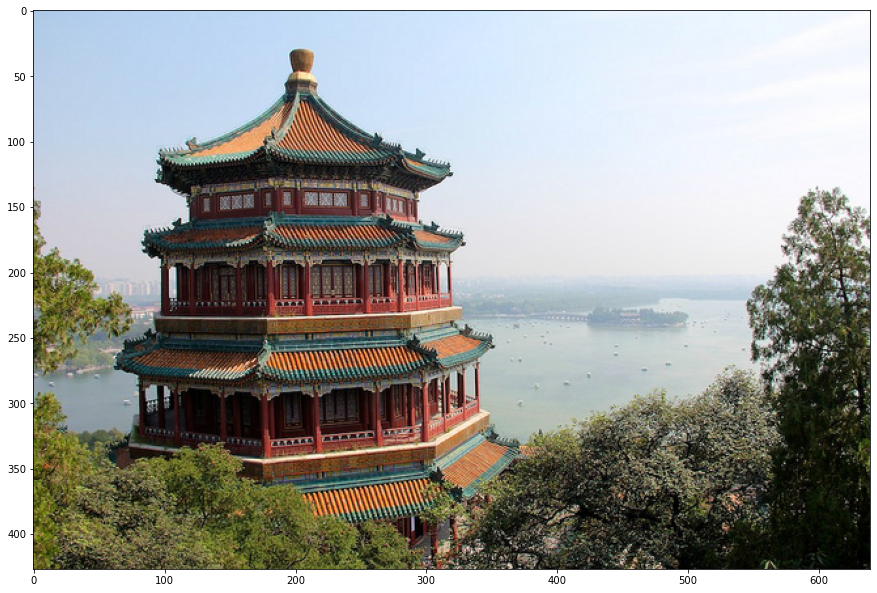

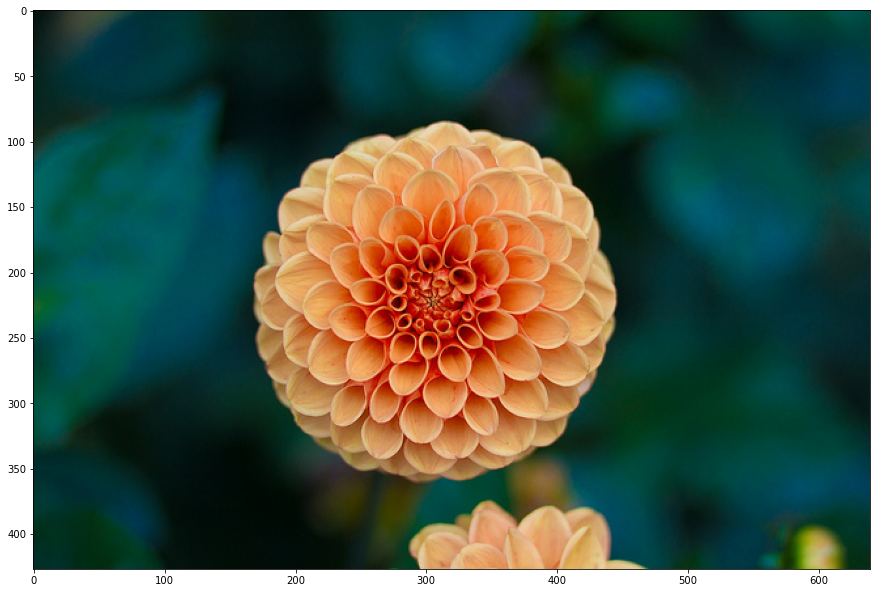

In [25]:
china = load_sample_image("china.jpg")
plt.figure(figsize=(15, 15))
plt.imshow(china)
# china
# china.shape  #(427, 640, 3), 427行，640列，3个通道
# china.dtype  # dtype('uint8'), 0-255, 8位无符号整数
# 对于灰度图像，每个像素点只包含一个 8 位无符号整数，用于表示灰度值。因此，灰度图像的数据类型通常称为“uint8”或“unsigned char”
newimage = china.reshape((427 * 640, 3))  #将图片转换为427*640行，3列的数据，每一行代表一个像素点的RGB值

import pandas as pd

pd.DataFrame(newimage).drop_duplicates().shape  #查看图片中有多少种颜色

flower = load_sample_image("flower.jpg")
plt.figure(figsize=(15, 15))
plt.imshow(flower)
plt.show()

图像探索完毕，我们了解了，图像现在有9W多种颜色。我们希望来试试看，能否使用K-Means将颜色压缩到64种，还不严重损耗图像的质量。为此，我们要**使用K-Means来将9W种颜色聚类成64类，然后使用64个簇的质心来替代全部的9W种颜色**，记得质心有着这样的性质：簇中的点都是离质心最近的样本点。为了比较，我们还要画出随机压缩到64种颜色的矢量量化图像。我们需要随机选取64个样本点作为随机质心，计算原数据中每个样本到它们的距离来找出离每个样本最近的随机质心，然后用每个样本所对应的随机质心来替换原本的样本。两种状况下，我们观察图像可视化之后的状况，以查看图片信息的损失。在这之前，我们需要把数据处理成sklearn中的K-Means类能够接受的数据。

**3. 决定超参数，数据预处理**

In [45]:
n_clusters = 64
# 将图片数据转换为浮点数，且将数据缩放到0-1之间
china = np.array(china, dtype=np.float64) / china.max()
w, h, d = original_shape = tuple(china.shape)  # 427, 640, 3
assert d == 3  # 保证图片是RGB三通道的。assert 是一个 Python 内置函数，用于在代码块中抛出一个断言，以便在代码执行期间检查条件是否成立。
# 将图片数据转换为427*640行，3列的数据
image_array = np.reshape(china, (w * h, d))
# image_array
# image_array.shape # (273280, 3)

**4.对数据进行K-Means的矢量量化**


In [68]:
image_array_sample = shuffle(image_array, random_state=0)[:1000]  # 打乱数据，取前1000个样本
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(image_array_sample)
# kmeans.cluster_centers_.shape  # (64, 3)

labels = kmeans.predict(image_array)
# labels.shape  # (273280,)

image_kmeans = image_array.copy()
for i in range(w * h):
    image_kmeans[i] = kmeans.cluster_centers_[labels[i]]  # 将每个样本点替换为对应质心的值
# image_kmeans
# pd.DataFrame(image_kmeans).drop_duplicates().shape  # (64, 3), 64种颜色

image_kmeans = np.reshape(image_kmeans, (w, h, d))  # 将数据转换为427行，640列，3通道的数据
# image_kmeans.shape  # (427, 640, 3)

**5.对数据进行随机矢量量化**

In [69]:
centroid_random = shuffle(image_array, random_state=0)[:n_clusters]  # 随机选取64个样本点作为随机质心
# 计算原数据中每个样本到它们的距离来找出离每个样本最近的随机质心
labels_random = pairwise_distances_argmin(centroid_random, image_array, axis=0)
# labels_random.shape # (273280,)
# len(set(labels_random)) # 64, 64个质心, 64种颜色
image_random = image_array.copy()
for i in range(w * h):
    image_random[i] = centroid_random[labels_random[i]]
image_random = image_random.reshape(w, h, d)
# image_random.shape # (427, 640, 3)

**6.将原图，按KMeans矢量量化和随机矢量量化的图像绘制出来**

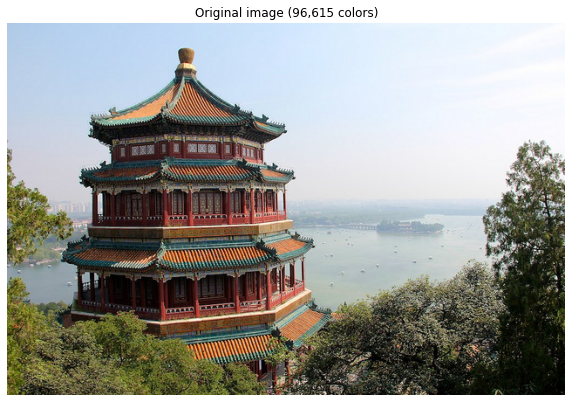

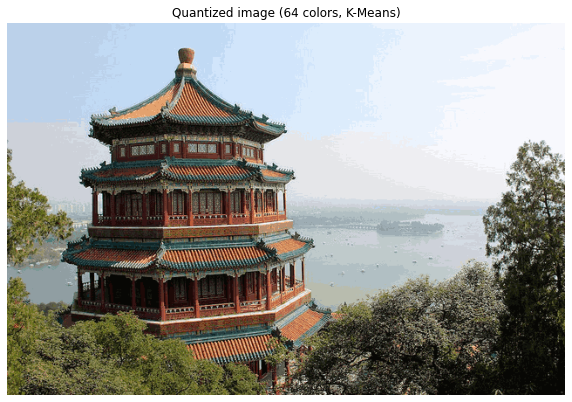

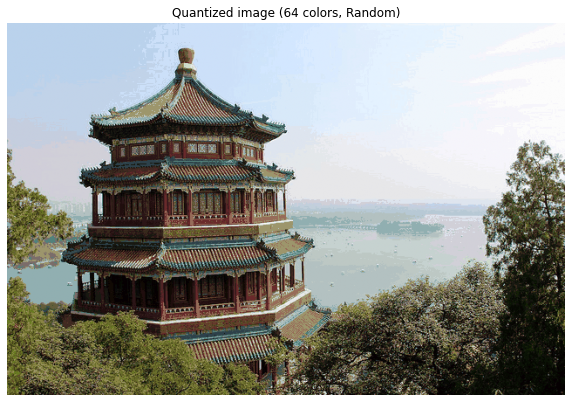

In [71]:
plt.figure(figsize=(10,10))
plt.axis('off') # 不显示坐标轴
plt.title('Original image (96,615 colors)')
plt.imshow(china)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(image_kmeans)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(image_random)
plt.show()